In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [ ]:
def compute_psnr(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    psnr_val = 0.0
    for i in range(b_size):
        psnr_val += psnr(
            real_batch[i, :, :, :].transpose(1, 2, 0),
            fake_batch[i, :, :, :].transpose(1, 2, 0),
            data_range=1.0,
        )
    return psnr_val / b_size

In [ ]:
def compute_ssim(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    ssim_val = 0.0
    for i in range(b_size):
        ssim_val += ssim(
            real_batch[i, :, :, :],
            fake_batch[i, :, :, :],
            channel_axis=0,
            data_range=1.0,
        )
    return ssim_val / b_size

In [ ]:
seed = 999
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# Dataset configuration
dataset_root = "data"
t1_train_data = "/content/drive/MyDrive/data/T1"
# Original image size is 240, so compress by 4 time
image_size = 64
num_workers = 16

# Critic model configuration
use_gp = True
lambda_gp = 10
# clipping param won't be used if use_gp is True
clipping_param = 0.01

# Generator model configuration
latent_size = 128
feature_map_size = image_size

# Training configuration
device = torch.device("cuda:0")
batch_size = 32
n_epochs = 200
n_critic = 5
lr = 0.001
beta1 = 0.5

In [ ]:
image_paths = [os.path.join(t1_train_data, impath) for impath in os.listdir(t1_train_data)]
tf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    ])
dataset = Data(image_paths, tf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
real_batch = next(iter(dataloader))

torch.Size([32, 1, 64, 64])


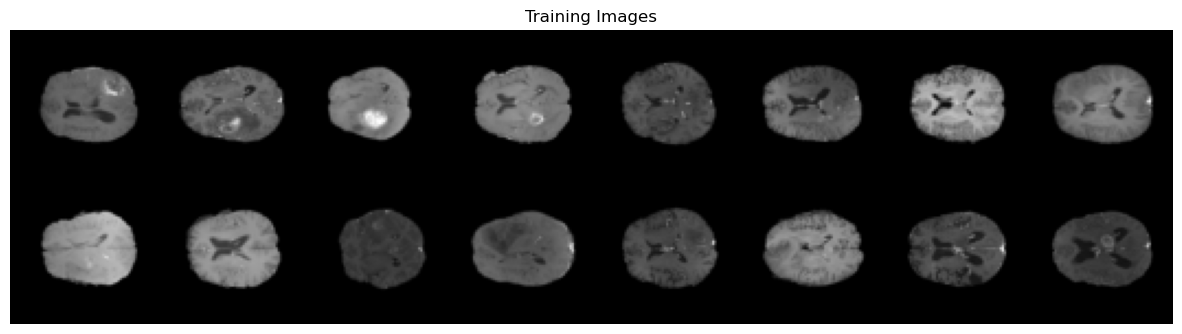

In [ ]:
# Plot some training images
print(real_batch.shape)
# Actually plot it
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch.to(device)[:16], padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)

In [ ]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [ ]:
class Critic(nn.Module):
    def __init__(self, use_gp=False) -> None:
        super(Critic, self).__init__()
        if use_gp:
            self.main = nn.Sequential(
                # input: 1 x image_size x image_size
                nn.Conv2d(1, feature_map_size, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size x image_size/2 x image_size/2
                nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*2 x image_size/4 x image_size/4
                nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*4 x image_size/8 x image_size/8
                nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*8 x image_size/16 x image_size/16
                nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0),
                # output: 1 x 1 x 1
            )
        else:
            self.main = nn.Sequential(
                # input: 1 x image_size x image_size
                nn.Conv2d(1, feature_map_size, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size),
                nn.LeakyReLU(0.2),
                # input: feature_map_size x image_size/2 x image_size/2
                nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 2),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*2 x image_size/4 x image_size/4
                nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 4),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*4 x image_size/8 x image_size/8
                nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 8),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*8 x image_size/16 x image_size/16
                nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0),
                # output: 1 x 1 x 1
            )

    def forward(self, input):
        return self.main(input)

In [ ]:
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)

Critic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [ ]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*16 x image_size/16 x image_size/16
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*8 x image_size/8 x image_size/8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*4 x image_size/4 x image_size/4
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*2 x image_size/2 x image_size/2
            nn.ConvTranspose2d(feature_map_size, 1, 4, 2, 1),
            nn.Tanh(),
            # output: 1 x image_size x image_size
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
generator_model = Generator().to(device)
generator_model.apply(weight_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [ ]:
optimizer_generator = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training loop
print("Starting training....")
fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)
img_list = list()
d_loss_hist = list()
g_loss_hist = list()
psnr_hist = list()
ssim_hist = list()
best_psnr = -float("inf")
best_ssim = -float("inf")
best_g_weights = None
best_d_weights = None

print(f"Number of mini batch iterations per epoch: {len(dataloader)}")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(dataloader, 0)):
        # Get batch of data
        real_batch = data.to(device)
        b_size = real_batch.shape[0]
        if b_size != batch_size:
            # drop last batch
            continue

        d_loss_vals = list()
        for _ in range(n_critic):
            # Train critic weight for real images
            critic_model.zero_grad()
            d_loss_real = critic_model(real_batch)

            # Update critic weight for fake images
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)
            fake_batch = generator_model(noise)
            d_loss_fake = critic_model(fake_batch)

            d_loss = -torch.mean(d_loss_real - d_loss_fake)
            if use_gp:
                # Random weight term for interpolation
                alpha = torch.rand(b_size, 1, 1, 1).to(device)
                # Get random interpolations between real and fake
                interpolates = torch.autograd.Variable(alpha * real_batch + (1 - alpha) * fake_batch, requires_grad=True).to(device)
                d_interpolates = critic_model(interpolates)
                fake = torch.autograd.Variable(torch.Tensor(d_interpolates.size()).fill_(1.0), requires_grad=False).to(device)
                # Get gradient w.r.t interpolates
                gradients = torch.autograd.grad(
                    outputs=d_interpolates,
                    inputs=interpolates,
                    grad_outputs=fake,
                    create_graph=True,
                )[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                d_loss += lambda_gp * gradient_penalty
            d_loss_vals.append(d_loss.detach().cpu().numpy())
            d_loss.backward()
            optimizer_critic.step()

            if use_gp:
                # no op
                ...
            else:
                # Clamp critic weights
                for p in critic_model.parameters():
                    p.data.clamp_(-clipping_param, clipping_param)

        d_loss_hist.append(np.mean(d_loss_vals))

        # Update generator weight
        generator_model.zero_grad()
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake_batch = generator_model(noise)
        output = critic_model(fake_batch)
        g_loss = -torch.mean(output)
        g_loss_hist.append(g_loss.detach().cpu().numpy())
        g_loss.backward()
        optimizer_generator.step()

        # Save best model based on PSNR every iteration
        psnr_hist.append(
            compute_psnr(
                real_batch.detach().cpu().numpy(),
                fake_batch.detach().cpu().numpy()
            )
        )
        ssim_hist.append(
            compute_ssim(
                real_batch.detach().cpu().numpy(),
                fake_batch.detach().cpu().numpy()
            )
        )
        if psnr_hist[-1] > best_psnr:
            best_psnr = psnr_hist[-1]
            best_ssim = ssim_hist[-1]
            best_g_weights = generator_model.state_dict()
            best_d_weights = critic_model.state_dict()

    tqdm.write("\n".join((
        f"epoch: {epoch}, d_loss: {d_loss_hist[-1]:.4f}, g_loss: {g_loss_hist[-1]:.4f} ",
        f"psnr: {psnr_hist[-1]:.4f}, best_psnr: {best_psnr:.4f} ",
        f"ssim: {ssim_hist[-1]:.4f}, best_ssim: {best_ssim:.4f} ",
    )))


Starting training....
Number of mini batch iterations per epoch: 12


12it [00:07,  1.57it/s]

epoch: 0, d_loss: -6877.0391, g_loss: 45730.7891 
psnr: 11.1072, best_psnr: 11.1072 
ssim: 0.0225, best_ssim: 0.0225 



12it [00:06,  1.81it/s]

epoch: 1, d_loss: -1191.9199, g_loss: 16462.4102 
psnr: 15.9918, best_psnr: 16.3405 
ssim: 0.1695, best_ssim: 0.1318 



12it [00:05,  2.04it/s]

epoch: 2, d_loss: -845.8271, g_loss: 25130.1953 
psnr: 18.7183, best_psnr: 18.7183 
ssim: 0.1838, best_ssim: 0.1838 



12it [00:05,  2.06it/s]

epoch: 3, d_loss: -375.8744, g_loss: 20115.7266 
psnr: 19.5631, best_psnr: 19.6439 
ssim: 0.3284, best_ssim: 0.2918 



12it [00:05,  2.02it/s]

epoch: 4, d_loss: -187.1307, g_loss: 15350.7598 
psnr: 19.2600, best_psnr: 20.4957 
ssim: 0.3659, best_ssim: 0.3544 



12it [00:06,  1.92it/s]

epoch: 5, d_loss: -260.7679, g_loss: 13000.3086 
psnr: 19.7059, best_psnr: 20.4957 
ssim: 0.3695, best_ssim: 0.3544 



12it [00:06,  1.97it/s]

epoch: 6, d_loss: -198.6643, g_loss: 22731.5762 
psnr: 19.4917, best_psnr: 20.4957 
ssim: 0.3356, best_ssim: 0.3544 



12it [00:05,  2.03it/s]

epoch: 7, d_loss: -187.9689, g_loss: 28533.6250 
psnr: 18.4288, best_psnr: 20.4957 
ssim: 0.3446, best_ssim: 0.3544 



12it [00:05,  2.10it/s]

epoch: 8, d_loss: -324.3369, g_loss: 17669.0117 
psnr: 20.2781, best_psnr: 20.6457 
ssim: 0.3282, best_ssim: 0.4152 



12it [00:05,  2.01it/s]

epoch: 9, d_loss: -196.7948, g_loss: 20873.2227 
psnr: 19.7135, best_psnr: 20.7539 
ssim: 0.3654, best_ssim: 0.3552 



12it [00:05,  2.03it/s]

epoch: 10, d_loss: -64.0608, g_loss: 21638.5508 
psnr: 21.0827, best_psnr: 21.0827 
ssim: 0.3891, best_ssim: 0.3891 



12it [00:05,  2.01it/s]


epoch: 11, d_loss: -146.4836, g_loss: 21244.6680 
psnr: 19.8555, best_psnr: 21.0827 
ssim: 0.3349, best_ssim: 0.3891 


12it [00:05,  2.06it/s]

epoch: 12, d_loss: -37.0384, g_loss: 21633.2227 
psnr: 20.4459, best_psnr: 21.4407 
ssim: 0.3682, best_ssim: 0.4771 



12it [00:05,  2.08it/s]

epoch: 13, d_loss: -171.3731, g_loss: 19687.8672 
psnr: 20.2216, best_psnr: 21.4407 
ssim: 0.4630, best_ssim: 0.4771 



12it [00:05,  2.05it/s]

epoch: 14, d_loss: 17.5617, g_loss: 17172.9746 
psnr: 19.7730, best_psnr: 21.4407 
ssim: 0.2859, best_ssim: 0.4771 



12it [00:06,  1.99it/s]

epoch: 15, d_loss: -253.0375, g_loss: 17526.8438 
psnr: 19.4689, best_psnr: 21.4407 
ssim: 0.2493, best_ssim: 0.4771 



12it [00:06,  1.93it/s]

epoch: 16, d_loss: -168.3139, g_loss: 16335.3740 
psnr: 20.0479, best_psnr: 21.4407 
ssim: 0.3662, best_ssim: 0.4771 



12it [00:06,  1.98it/s]

epoch: 17, d_loss: 86.6913, g_loss: 11538.9551 
psnr: 20.9058, best_psnr: 21.6494 
ssim: 0.4669, best_ssim: 0.4948 



12it [00:05,  2.00it/s]

epoch: 18, d_loss: 33.6454, g_loss: 16672.6270 
psnr: 20.5155, best_psnr: 22.3231 
ssim: 0.4833, best_ssim: 0.5823 



12it [00:06,  2.00it/s]

epoch: 19, d_loss: -454.6996, g_loss: 17668.5234 
psnr: 19.8729, best_psnr: 22.3231 
ssim: 0.2457, best_ssim: 0.5823 



12it [00:06,  1.97it/s]

epoch: 20, d_loss: -45.0832, g_loss: 9464.2754 
psnr: 21.7595, best_psnr: 22.3231 
ssim: 0.4867, best_ssim: 0.5823 



12it [00:06,  1.98it/s]

epoch: 21, d_loss: -136.4273, g_loss: 6488.6250 
psnr: 21.0709, best_psnr: 22.6634 
ssim: 0.5477, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 22, d_loss: -669.5286, g_loss: 17913.4629 
psnr: 19.5817, best_psnr: 22.6634 
ssim: 0.4511, best_ssim: 0.4809 



12it [00:06,  1.85it/s]

epoch: 23, d_loss: -335.8710, g_loss: 21286.3770 
psnr: 20.2452, best_psnr: 22.6634 
ssim: 0.2797, best_ssim: 0.4809 



12it [00:06,  1.93it/s]

epoch: 24, d_loss: -5.8208, g_loss: 10588.3779 
psnr: 20.9725, best_psnr: 22.6634 
ssim: 0.4936, best_ssim: 0.4809 



12it [00:06,  1.91it/s]

epoch: 25, d_loss: -862.6627, g_loss: 21490.3535 
psnr: 18.0417, best_psnr: 22.6634 
ssim: 0.1115, best_ssim: 0.4809 



12it [00:06,  1.95it/s]

epoch: 26, d_loss: -108.5685, g_loss: 1073.1868 
psnr: 19.4547, best_psnr: 22.6634 
ssim: 0.2699, best_ssim: 0.4809 



12it [00:06,  1.89it/s]

epoch: 27, d_loss: -258.0488, g_loss: 10160.3633 
psnr: 19.3990, best_psnr: 22.6634 
ssim: 0.2918, best_ssim: 0.4809 



12it [00:06,  1.87it/s]

epoch: 28, d_loss: -46.1145, g_loss: 3699.8716 
psnr: 21.4290, best_psnr: 22.6634 
ssim: 0.5801, best_ssim: 0.4809 



12it [00:06,  1.95it/s]

epoch: 29, d_loss: -1.8146, g_loss: 5097.0469 
psnr: 22.0015, best_psnr: 22.6634 
ssim: 0.6169, best_ssim: 0.4809 



12it [00:06,  1.97it/s]

epoch: 30, d_loss: -165.0718, g_loss: -1087.2661 
psnr: 22.0588, best_psnr: 22.6634 
ssim: 0.4354, best_ssim: 0.4809 



12it [00:06,  1.95it/s]

epoch: 31, d_loss: 0.3531, g_loss: 3493.9497 
psnr: 21.2111, best_psnr: 22.6634 
ssim: 0.6511, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 32, d_loss: 136.1057, g_loss: 4574.1226 
psnr: 20.9734, best_psnr: 22.6634 
ssim: 0.6298, best_ssim: 0.4809 



12it [00:06,  1.92it/s]

epoch: 33, d_loss: -198.8095, g_loss: 2990.1851 
psnr: 20.0115, best_psnr: 22.6634 
ssim: 0.5152, best_ssim: 0.4809 



12it [00:06,  1.82it/s]

epoch: 34, d_loss: -88.7483, g_loss: 7238.8970 
psnr: 21.4508, best_psnr: 22.6634 
ssim: 0.5771, best_ssim: 0.4809 



12it [00:06,  1.77it/s]

epoch: 35, d_loss: -112.5847, g_loss: 4700.2217 
psnr: 20.0486, best_psnr: 22.6634 
ssim: 0.4599, best_ssim: 0.4809 



12it [00:06,  1.95it/s]

epoch: 36, d_loss: -77.7595, g_loss: 6172.5308 
psnr: 19.5755, best_psnr: 22.6634 
ssim: 0.4944, best_ssim: 0.4809 



12it [00:06,  1.94it/s]

epoch: 37, d_loss: -220.1994, g_loss: 935.9990 
psnr: 18.9260, best_psnr: 22.6634 
ssim: 0.3234, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 38, d_loss: -131.7496, g_loss: 4004.4248 
psnr: 19.6182, best_psnr: 22.6634 
ssim: 0.5326, best_ssim: 0.4809 



12it [00:06,  1.94it/s]

epoch: 39, d_loss: 41.2794, g_loss: 8270.7383 
psnr: 20.7816, best_psnr: 22.6634 
ssim: 0.3551, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 40, d_loss: -104.1439, g_loss: 978.7904 
psnr: 20.5862, best_psnr: 22.6634 
ssim: 0.6280, best_ssim: 0.4809 



12it [00:06,  1.88it/s]

epoch: 41, d_loss: -279.1443, g_loss: -1802.7290 
psnr: 19.8599, best_psnr: 22.6634 
ssim: 0.4905, best_ssim: 0.4809 



12it [00:06,  1.98it/s]

epoch: 42, d_loss: -74.9579, g_loss: 13858.2461 
psnr: 20.5606, best_psnr: 22.6634 
ssim: 0.5425, best_ssim: 0.4809 



12it [00:06,  1.96it/s]


epoch: 43, d_loss: -36.9465, g_loss: -1140.5891 
psnr: 20.8511, best_psnr: 22.6634 
ssim: 0.5952, best_ssim: 0.4809 


12it [00:06,  1.94it/s]

epoch: 44, d_loss: -460.5007, g_loss: -6138.4561 
psnr: 20.2083, best_psnr: 22.6634 
ssim: 0.5119, best_ssim: 0.4809 



12it [00:05,  2.01it/s]

epoch: 45, d_loss: -35.8227, g_loss: 13402.0352 
psnr: 19.2162, best_psnr: 22.6634 
ssim: 0.3228, best_ssim: 0.4809 



12it [00:05,  2.08it/s]

epoch: 46, d_loss: -27.6544, g_loss: -2055.6050 
psnr: 19.4480, best_psnr: 22.6634 
ssim: 0.6242, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 47, d_loss: -201.1349, g_loss: -3015.0005 
psnr: 19.3215, best_psnr: 22.6634 
ssim: 0.5987, best_ssim: 0.4809 



12it [00:05,  2.12it/s]

epoch: 48, d_loss: -150.2863, g_loss: 12266.6973 
psnr: 19.6871, best_psnr: 22.6634 
ssim: 0.5728, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 49, d_loss: -165.4644, g_loss: 389.5129 
psnr: 20.3080, best_psnr: 22.6634 
ssim: 0.6209, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 50, d_loss: -37.9194, g_loss: 844.1707 
psnr: 20.7261, best_psnr: 22.6634 
ssim: 0.6269, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 51, d_loss: -84.9037, g_loss: 6656.0850 
psnr: 20.7180, best_psnr: 22.6634 
ssim: 0.6153, best_ssim: 0.4809 



12it [00:05,  2.11it/s]


epoch: 52, d_loss: 43.4944, g_loss: 2449.7893 
psnr: 20.5504, best_psnr: 22.6634 
ssim: 0.4190, best_ssim: 0.4809 


12it [00:05,  2.10it/s]

epoch: 53, d_loss: -45.1858, g_loss: -3465.8201 
psnr: 19.8822, best_psnr: 22.6634 
ssim: 0.4972, best_ssim: 0.4809 



12it [00:05,  2.09it/s]


epoch: 54, d_loss: -400.9262, g_loss: -7372.2822 
psnr: 19.1436, best_psnr: 22.6634 
ssim: 0.4861, best_ssim: 0.4809 


12it [00:05,  2.10it/s]

epoch: 55, d_loss: -102.4985, g_loss: 1234.7455 
psnr: 19.4324, best_psnr: 22.6634 
ssim: 0.4556, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 56, d_loss: -126.6861, g_loss: 4541.4336 
psnr: 20.8348, best_psnr: 22.6634 
ssim: 0.3427, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 57, d_loss: -313.2063, g_loss: 15490.9883 
psnr: 20.9499, best_psnr: 22.6634 
ssim: 0.2958, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 58, d_loss: 6.9040, g_loss: 7764.8818 
psnr: 19.3982, best_psnr: 22.6634 
ssim: 0.5955, best_ssim: 0.4809 



12it [00:05,  2.13it/s]

epoch: 59, d_loss: 143.5225, g_loss: 12367.9492 
psnr: 19.6217, best_psnr: 22.6634 
ssim: 0.4317, best_ssim: 0.4809 



12it [00:05,  2.11it/s]

epoch: 60, d_loss: -144.9801, g_loss: 10785.3340 
psnr: 20.2011, best_psnr: 22.6634 
ssim: 0.4900, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 61, d_loss: -194.7594, g_loss: 12875.4209 
psnr: 20.2088, best_psnr: 22.6634 
ssim: 0.2968, best_ssim: 0.4809 



12it [00:05,  2.12it/s]


epoch: 62, d_loss: -113.4899, g_loss: 11166.1621 
psnr: 20.9041, best_psnr: 22.6634 
ssim: 0.5653, best_ssim: 0.4809 


12it [00:05,  2.03it/s]

epoch: 63, d_loss: -160.7183, g_loss: 1187.3805 
psnr: 21.3101, best_psnr: 22.6634 
ssim: 0.4254, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 64, d_loss: -51.3969, g_loss: 671.3628 
psnr: 21.2674, best_psnr: 22.6634 
ssim: 0.6768, best_ssim: 0.4809 



12it [00:05,  2.06it/s]

epoch: 65, d_loss: -108.1720, g_loss: 2895.9299 
psnr: 20.3884, best_psnr: 22.6634 
ssim: 0.6558, best_ssim: 0.4809 



12it [00:05,  2.09it/s]


epoch: 66, d_loss: -88.9402, g_loss: 4626.6377 
psnr: 21.1599, best_psnr: 22.6634 
ssim: 0.6505, best_ssim: 0.4809 


12it [00:05,  2.08it/s]

epoch: 67, d_loss: -136.5437, g_loss: 3031.9902 
psnr: 20.7576, best_psnr: 22.6634 
ssim: 0.6628, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 68, d_loss: -126.7747, g_loss: 2531.3079 
psnr: 20.4495, best_psnr: 22.6634 
ssim: 0.5714, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 69, d_loss: -62.6518, g_loss: 3473.1934 
psnr: 20.3432, best_psnr: 22.6634 
ssim: 0.6091, best_ssim: 0.4809 



12it [00:05,  2.07it/s]

epoch: 70, d_loss: 185.3221, g_loss: 4107.2637 
psnr: 20.2033, best_psnr: 22.6634 
ssim: 0.3611, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 71, d_loss: -79.3050, g_loss: 452.9010 
psnr: 20.9364, best_psnr: 22.6634 
ssim: 0.5929, best_ssim: 0.4809 



12it [00:05,  2.07it/s]

epoch: 72, d_loss: 36.0120, g_loss: 2044.0685 
psnr: 20.9457, best_psnr: 22.6634 
ssim: 0.3639, best_ssim: 0.4809 



12it [00:05,  2.07it/s]

epoch: 73, d_loss: 29.4016, g_loss: 1134.7694 
psnr: 19.3892, best_psnr: 22.6634 
ssim: 0.2614, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 74, d_loss: -96.0236, g_loss: 10886.5898 
psnr: 20.7123, best_psnr: 22.6634 
ssim: 0.5035, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 75, d_loss: -80.1709, g_loss: 11235.8281 
psnr: 19.9455, best_psnr: 22.6634 
ssim: 0.6199, best_ssim: 0.4809 



12it [00:05,  2.12it/s]


epoch: 76, d_loss: -62.1031, g_loss: 1786.1182 
psnr: 21.1605, best_psnr: 22.6634 
ssim: 0.6422, best_ssim: 0.4809 


12it [00:05,  2.09it/s]

epoch: 77, d_loss: -403.6430, g_loss: 5625.1104 
psnr: 20.8561, best_psnr: 22.6634 
ssim: 0.3383, best_ssim: 0.4809 



12it [00:05,  2.12it/s]

epoch: 78, d_loss: -184.3777, g_loss: 16533.0430 
psnr: 20.4697, best_psnr: 22.6634 
ssim: 0.3898, best_ssim: 0.4809 



12it [00:05,  2.08it/s]

epoch: 79, d_loss: -341.3795, g_loss: 12039.9971 
psnr: 19.4251, best_psnr: 22.6634 
ssim: 0.4055, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 80, d_loss: -228.2799, g_loss: -7141.2158 
psnr: 19.8996, best_psnr: 22.6634 
ssim: 0.4832, best_ssim: 0.4809 



12it [00:05,  2.08it/s]


epoch: 81, d_loss: -170.1421, g_loss: -8661.2637 
psnr: 20.0481, best_psnr: 22.6634 
ssim: 0.4277, best_ssim: 0.4809 


12it [00:05,  2.06it/s]

epoch: 82, d_loss: -76.4201, g_loss: 7908.4121 
psnr: 19.0374, best_psnr: 22.6634 
ssim: 0.5988, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 83, d_loss: -159.3566, g_loss: 4248.0234 
psnr: 20.0421, best_psnr: 22.6634 
ssim: 0.5283, best_ssim: 0.4809 



12it [00:05,  2.14it/s]

epoch: 84, d_loss: -441.9779, g_loss: 44423.8359 
psnr: 20.1891, best_psnr: 22.6634 
ssim: 0.3178, best_ssim: 0.4809 



12it [00:05,  2.06it/s]

epoch: 85, d_loss: 52.4384, g_loss: 3637.5535 
psnr: 19.8319, best_psnr: 22.6634 
ssim: 0.4937, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 86, d_loss: -12.9376, g_loss: -675.4564 
psnr: 20.7572, best_psnr: 22.6634 
ssim: 0.6473, best_ssim: 0.4809 



12it [00:05,  2.11it/s]

epoch: 87, d_loss: -84.8937, g_loss: -7580.8115 
psnr: 20.1843, best_psnr: 22.6634 
ssim: 0.6433, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 88, d_loss: -219.7150, g_loss: 1358.9911 
psnr: 20.3475, best_psnr: 22.6634 
ssim: 0.5845, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 89, d_loss: -72.2297, g_loss: -5452.1392 
psnr: 20.0789, best_psnr: 22.6634 
ssim: 0.6136, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 90, d_loss: -530.9692, g_loss: -7578.6328 
psnr: 20.5471, best_psnr: 22.6634 
ssim: 0.4994, best_ssim: 0.4809 



12it [00:05,  2.14it/s]

epoch: 91, d_loss: -155.8014, g_loss: -6777.6328 
psnr: 19.7398, best_psnr: 22.6634 
ssim: 0.2918, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 92, d_loss: -90.3462, g_loss: -4788.1602 
psnr: 19.6539, best_psnr: 22.6634 
ssim: 0.3081, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 93, d_loss: -93.1865, g_loss: -901.8560 
psnr: 19.7997, best_psnr: 22.6634 
ssim: 0.6283, best_ssim: 0.4809 



12it [00:05,  2.12it/s]


epoch: 94, d_loss: -28.1116, g_loss: -2375.5869 
psnr: 21.6086, best_psnr: 22.6634 
ssim: 0.5595, best_ssim: 0.4809 


12it [00:05,  2.05it/s]


epoch: 95, d_loss: 241.5059, g_loss: -1420.9789 
psnr: 20.6191, best_psnr: 22.6634 
ssim: 0.4106, best_ssim: 0.4809 


12it [00:05,  2.07it/s]

epoch: 96, d_loss: -256.3561, g_loss: 19073.1719 
psnr: 19.2998, best_psnr: 22.6634 
ssim: 0.3113, best_ssim: 0.4809 



12it [00:05,  2.12it/s]

epoch: 97, d_loss: -749.5379, g_loss: -24587.2461 
psnr: 19.9361, best_psnr: 22.6634 
ssim: 0.4685, best_ssim: 0.4809 



12it [00:05,  2.10it/s]


epoch: 98, d_loss: -148.9971, g_loss: 6693.2012 
psnr: 21.0015, best_psnr: 22.6634 
ssim: 0.6376, best_ssim: 0.4809 


12it [00:05,  2.03it/s]

epoch: 99, d_loss: -266.2720, g_loss: 19143.8223 
psnr: 20.7302, best_psnr: 22.6634 
ssim: 0.6496, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 100, d_loss: -164.0690, g_loss: 4282.8262 
psnr: 21.4983, best_psnr: 22.6634 
ssim: 0.4680, best_ssim: 0.4809 



12it [00:06,  1.98it/s]

epoch: 101, d_loss: 225.7795, g_loss: 3724.2334 
psnr: 20.3104, best_psnr: 22.6634 
ssim: 0.5628, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 102, d_loss: -134.9236, g_loss: 2686.0952 
psnr: 19.3706, best_psnr: 22.6634 
ssim: 0.4999, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 103, d_loss: -34.5822, g_loss: -6302.9580 
psnr: 20.2970, best_psnr: 22.6634 
ssim: 0.6278, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 104, d_loss: -80.8587, g_loss: 6230.8579 
psnr: 20.5033, best_psnr: 22.6634 
ssim: 0.6166, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 105, d_loss: -72.7267, g_loss: -1855.3896 
psnr: 21.3454, best_psnr: 22.6634 
ssim: 0.3849, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 106, d_loss: -313.6686, g_loss: -9597.7949 
psnr: 19.9790, best_psnr: 22.6634 
ssim: 0.5305, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 107, d_loss: -27.1009, g_loss: 5484.0854 
psnr: 19.9126, best_psnr: 22.6634 
ssim: 0.5598, best_ssim: 0.4809 



12it [00:06,  1.96it/s]


epoch: 108, d_loss: -49.7044, g_loss: 1644.9062 
psnr: 19.6577, best_psnr: 22.6634 
ssim: 0.5998, best_ssim: 0.4809 


12it [00:06,  1.97it/s]


epoch: 109, d_loss: -78.1983, g_loss: -1989.3955 
psnr: 20.7951, best_psnr: 22.6634 
ssim: 0.6476, best_ssim: 0.4809 


12it [00:06,  1.98it/s]

epoch: 110, d_loss: -204.3558, g_loss: -8755.9863 
psnr: 20.2691, best_psnr: 22.6634 
ssim: 0.6173, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 111, d_loss: -57.2250, g_loss: -3257.6174 
psnr: 20.2344, best_psnr: 22.6634 
ssim: 0.3943, best_ssim: 0.4809 



12it [00:06,  1.90it/s]

epoch: 112, d_loss: -77.3191, g_loss: -4372.0103 
psnr: 20.5917, best_psnr: 22.6634 
ssim: 0.5792, best_ssim: 0.4809 



12it [00:05,  2.01it/s]

epoch: 113, d_loss: -186.1336, g_loss: -15100.9414 
psnr: 19.8474, best_psnr: 22.6634 
ssim: 0.5364, best_ssim: 0.4809 



12it [00:06,  1.97it/s]

epoch: 114, d_loss: -178.2765, g_loss: 5642.9932 
psnr: 20.0635, best_psnr: 22.6634 
ssim: 0.6050, best_ssim: 0.4809 



12it [00:06,  1.97it/s]

epoch: 115, d_loss: -123.1687, g_loss: -543.6006 
psnr: 19.9657, best_psnr: 22.6634 
ssim: 0.4711, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 116, d_loss: -100.5439, g_loss: 3924.4141 
psnr: 19.5723, best_psnr: 22.6634 
ssim: 0.6149, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 117, d_loss: -56.6169, g_loss: 7681.7627 
psnr: 20.6998, best_psnr: 22.6634 
ssim: 0.4358, best_ssim: 0.4809 



12it [00:05,  2.07it/s]

epoch: 118, d_loss: -29.6462, g_loss: -1592.8398 
psnr: 19.8576, best_psnr: 22.6634 
ssim: 0.6309, best_ssim: 0.4809 



12it [00:05,  2.00it/s]

epoch: 119, d_loss: 62.2680, g_loss: -5922.3115 
psnr: 19.8797, best_psnr: 22.6634 
ssim: 0.6289, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 120, d_loss: -73.1025, g_loss: -2016.9491 
psnr: 20.0824, best_psnr: 22.6634 
ssim: 0.6249, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 121, d_loss: -81.1389, g_loss: -3950.3809 
psnr: 20.6730, best_psnr: 22.6634 
ssim: 0.6403, best_ssim: 0.4809 



12it [00:06,  1.95it/s]

epoch: 122, d_loss: -76.4585, g_loss: 2533.5479 
psnr: 20.4210, best_psnr: 22.6634 
ssim: 0.6233, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 123, d_loss: -500.1147, g_loss: 18224.0645 
psnr: 20.5570, best_psnr: 22.6634 
ssim: 0.4137, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 124, d_loss: -126.7057, g_loss: 18294.4609 
psnr: 20.7054, best_psnr: 22.6634 
ssim: 0.5638, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 125, d_loss: -71.7476, g_loss: -8433.9297 
psnr: 19.5904, best_psnr: 22.6634 
ssim: 0.6450, best_ssim: 0.4809 



12it [00:05,  2.01it/s]

epoch: 126, d_loss: 8.2381, g_loss: 2139.7227 
psnr: 19.7782, best_psnr: 22.6634 
ssim: 0.5045, best_ssim: 0.4809 



12it [00:05,  2.08it/s]

epoch: 127, d_loss: -33.3674, g_loss: -6223.0635 
psnr: 20.3834, best_psnr: 22.6634 
ssim: 0.6107, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 128, d_loss: -81.1499, g_loss: 1315.7994 
psnr: 19.9158, best_psnr: 22.6634 
ssim: 0.5954, best_ssim: 0.4809 



12it [00:05,  2.04it/s]

epoch: 129, d_loss: -232.5131, g_loss: 13772.7139 
psnr: 20.7041, best_psnr: 22.6634 
ssim: 0.5591, best_ssim: 0.4809 



12it [00:05,  2.00it/s]

epoch: 130, d_loss: -65.0268, g_loss: -5330.9355 
psnr: 19.8874, best_psnr: 22.6634 
ssim: 0.5328, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 131, d_loss: -98.0891, g_loss: -30880.3984 
psnr: 19.7416, best_psnr: 22.6634 
ssim: 0.4834, best_ssim: 0.4809 



12it [00:05,  2.01it/s]

epoch: 132, d_loss: -132.6014, g_loss: -12669.7031 
psnr: 19.6405, best_psnr: 22.6634 
ssim: 0.4086, best_ssim: 0.4809 



12it [00:05,  2.00it/s]

epoch: 133, d_loss: -138.6587, g_loss: 2587.8064 
psnr: 20.4510, best_psnr: 22.6634 
ssim: 0.6477, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 134, d_loss: -22.6675, g_loss: 2959.1599 
psnr: 20.4086, best_psnr: 22.6634 
ssim: 0.6600, best_ssim: 0.4809 



12it [00:06,  1.94it/s]

epoch: 135, d_loss: -34.9119, g_loss: -2082.4451 
psnr: 20.3890, best_psnr: 22.6634 
ssim: 0.5930, best_ssim: 0.4809 



12it [00:06,  1.98it/s]

epoch: 136, d_loss: -117.5094, g_loss: -2317.1868 
psnr: 19.7822, best_psnr: 22.6634 
ssim: 0.5808, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 137, d_loss: 14.2529, g_loss: 4771.2568 
psnr: 21.2073, best_psnr: 22.6634 
ssim: 0.6718, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 138, d_loss: 65.6457, g_loss: -217.8919 
psnr: 20.1748, best_psnr: 22.6634 
ssim: 0.4414, best_ssim: 0.4809 



12it [00:06,  1.92it/s]

epoch: 139, d_loss: -34.2924, g_loss: 2607.8423 
psnr: 20.4541, best_psnr: 22.6634 
ssim: 0.5811, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 140, d_loss: -61.9595, g_loss: 1849.4729 
psnr: 20.6986, best_psnr: 22.6634 
ssim: 0.6485, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 141, d_loss: -33.0517, g_loss: 5928.0742 
psnr: 20.9893, best_psnr: 22.6634 
ssim: 0.6612, best_ssim: 0.4809 



12it [00:05,  2.07it/s]

epoch: 142, d_loss: -47.5304, g_loss: 2379.2866 
psnr: 20.4966, best_psnr: 22.6634 
ssim: 0.6215, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 143, d_loss: -37.4878, g_loss: -1915.6002 
psnr: 21.2512, best_psnr: 22.6634 
ssim: 0.6654, best_ssim: 0.4809 



12it [00:06,  1.98it/s]

epoch: 144, d_loss: -54.0271, g_loss: 3250.3413 
psnr: 20.6452, best_psnr: 22.6634 
ssim: 0.6183, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 145, d_loss: -161.5457, g_loss: 18257.2266 
psnr: 19.1532, best_psnr: 22.6634 
ssim: 0.5214, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 146, d_loss: -76.6790, g_loss: 5731.5127 
psnr: 20.5977, best_psnr: 22.6634 
ssim: 0.5597, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 147, d_loss: -42.2015, g_loss: 2901.9836 
psnr: 20.8706, best_psnr: 22.6634 
ssim: 0.5332, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 148, d_loss: 140.0940, g_loss: 5962.8555 
psnr: 20.2279, best_psnr: 22.6634 
ssim: 0.3909, best_ssim: 0.4809 



12it [00:06,  1.96it/s]

epoch: 149, d_loss: -247.1812, g_loss: 6003.8535 
psnr: 19.3348, best_psnr: 22.6634 
ssim: 0.4845, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 150, d_loss: -177.8992, g_loss: 29342.1973 
psnr: 20.2380, best_psnr: 22.6634 
ssim: 0.4864, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 151, d_loss: -119.9243, g_loss: -13091.3730 
psnr: 20.5831, best_psnr: 22.6634 
ssim: 0.6268, best_ssim: 0.4809 



12it [00:05,  2.07it/s]

epoch: 152, d_loss: -92.2581, g_loss: 7375.0771 
psnr: 20.4843, best_psnr: 22.6634 
ssim: 0.5623, best_ssim: 0.4809 



12it [00:05,  2.07it/s]

epoch: 153, d_loss: 34.1355, g_loss: -1425.8818 
psnr: 19.8310, best_psnr: 22.6634 
ssim: 0.5996, best_ssim: 0.4809 



12it [00:05,  2.01it/s]

epoch: 154, d_loss: -16.4491, g_loss: 19634.9766 
psnr: 20.1662, best_psnr: 22.6634 
ssim: 0.6304, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 155, d_loss: -95.2164, g_loss: 5976.2578 
psnr: 19.7574, best_psnr: 22.6634 
ssim: 0.5519, best_ssim: 0.4809 



12it [00:05,  2.10it/s]

epoch: 156, d_loss: -37.5453, g_loss: -2248.7441 
psnr: 19.9210, best_psnr: 22.6634 
ssim: 0.5717, best_ssim: 0.4809 



12it [00:05,  2.06it/s]

epoch: 157, d_loss: -142.4925, g_loss: -13292.8145 
psnr: 20.6279, best_psnr: 22.6634 
ssim: 0.5695, best_ssim: 0.4809 



12it [00:05,  2.08it/s]


epoch: 158, d_loss: -52.9847, g_loss: -64.4893 
psnr: 20.4754, best_psnr: 22.6634 
ssim: 0.6490, best_ssim: 0.4809 


12it [00:06,  1.98it/s]

epoch: 159, d_loss: -228.8224, g_loss: -3454.4155 
psnr: 20.7132, best_psnr: 22.6634 
ssim: 0.3126, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 160, d_loss: -92.7939, g_loss: 7986.2109 
psnr: 19.8842, best_psnr: 22.6634 
ssim: 0.4427, best_ssim: 0.4809 



12it [00:05,  2.01it/s]

epoch: 161, d_loss: -52.2180, g_loss: -5123.5547 
psnr: 19.9211, best_psnr: 22.6634 
ssim: 0.6442, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 162, d_loss: -8.7880, g_loss: 2914.0859 
psnr: 19.6463, best_psnr: 22.6634 
ssim: 0.6249, best_ssim: 0.4809 



12it [00:06,  1.97it/s]

epoch: 163, d_loss: 35.3939, g_loss: -1461.8308 
psnr: 20.3715, best_psnr: 22.6634 
ssim: 0.6022, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 164, d_loss: -66.4920, g_loss: 3430.3774 
psnr: 19.9510, best_psnr: 22.6634 
ssim: 0.5008, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 165, d_loss: -47.2298, g_loss: 6928.8252 
psnr: 20.6379, best_psnr: 22.6634 
ssim: 0.6494, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 166, d_loss: -61.4710, g_loss: 3283.0195 
psnr: 21.3083, best_psnr: 22.6634 
ssim: 0.6451, best_ssim: 0.4809 



12it [00:06,  1.96it/s]

epoch: 167, d_loss: -24.4788, g_loss: 1555.3378 
psnr: 19.8747, best_psnr: 22.6634 
ssim: 0.6418, best_ssim: 0.4809 



12it [00:06,  1.95it/s]

epoch: 168, d_loss: -23.0364, g_loss: -1003.2808 
psnr: 20.6792, best_psnr: 22.6634 
ssim: 0.6560, best_ssim: 0.4809 



12it [00:06,  1.99it/s]


epoch: 169, d_loss: -22.9737, g_loss: 3988.4836 
psnr: 21.0810, best_psnr: 22.6634 
ssim: 0.6702, best_ssim: 0.4809 


12it [00:05,  2.13it/s]


epoch: 170, d_loss: -99.2550, g_loss: -7102.8374 
psnr: 19.4120, best_psnr: 22.6634 
ssim: 0.6084, best_ssim: 0.4809 


12it [00:05,  2.07it/s]

epoch: 171, d_loss: -123.8612, g_loss: 5625.9043 
psnr: 19.5028, best_psnr: 22.6634 
ssim: 0.4355, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 172, d_loss: -109.7311, g_loss: -13419.1328 
psnr: 20.1877, best_psnr: 22.6634 
ssim: 0.6098, best_ssim: 0.4809 



12it [00:05,  2.00it/s]

epoch: 173, d_loss: 38.5776, g_loss: -951.4354 
psnr: 19.7652, best_psnr: 22.6634 
ssim: 0.4750, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 174, d_loss: -174.2503, g_loss: 28575.6250 
psnr: 20.9871, best_psnr: 22.6634 
ssim: 0.5436, best_ssim: 0.4809 



12it [00:06,  1.97it/s]

epoch: 175, d_loss: -61.8294, g_loss: 17544.3027 
psnr: 20.7032, best_psnr: 22.6634 
ssim: 0.4421, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 176, d_loss: -73.1482, g_loss: 2705.5684 
psnr: 20.6256, best_psnr: 22.6634 
ssim: 0.6629, best_ssim: 0.4809 



12it [00:06,  1.98it/s]

epoch: 177, d_loss: -45.8254, g_loss: 7268.6152 
psnr: 21.2038, best_psnr: 22.6634 
ssim: 0.6391, best_ssim: 0.4809 



12it [00:06,  1.98it/s]

epoch: 178, d_loss: -44.3718, g_loss: -6241.8540 
psnr: 20.2457, best_psnr: 22.6634 
ssim: 0.5555, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 179, d_loss: -356.5480, g_loss: 19039.7422 
psnr: 19.3728, best_psnr: 22.6634 
ssim: 0.6244, best_ssim: 0.4809 



12it [00:06,  1.93it/s]

epoch: 180, d_loss: -44.7183, g_loss: 811.3785 
psnr: 20.1068, best_psnr: 22.6634 
ssim: 0.6485, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 181, d_loss: -30.0894, g_loss: 2767.5391 
psnr: 21.3028, best_psnr: 22.6634 
ssim: 0.6366, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 182, d_loss: -81.1563, g_loss: 7704.8691 
psnr: 20.6071, best_psnr: 22.6634 
ssim: 0.3850, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 183, d_loss: -48.2025, g_loss: -8211.0859 
psnr: 19.5630, best_psnr: 22.6634 
ssim: 0.6022, best_ssim: 0.4809 



12it [00:06,  1.90it/s]

epoch: 184, d_loss: -21.8314, g_loss: 1606.9661 
psnr: 20.4555, best_psnr: 22.6634 
ssim: 0.6564, best_ssim: 0.4809 



12it [00:06,  1.96it/s]

epoch: 185, d_loss: -52.0863, g_loss: -272.3904 
psnr: 20.1377, best_psnr: 22.6634 
ssim: 0.6579, best_ssim: 0.4809 



12it [00:06,  1.98it/s]

epoch: 186, d_loss: -76.3723, g_loss: -11853.3291 
psnr: 20.1046, best_psnr: 22.6634 
ssim: 0.6320, best_ssim: 0.4809 



12it [00:05,  2.01it/s]

epoch: 187, d_loss: -100.9844, g_loss: 1551.8199 
psnr: 20.2506, best_psnr: 22.6634 
ssim: 0.4741, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 188, d_loss: -73.6456, g_loss: -3265.5273 
psnr: 19.7204, best_psnr: 22.6634 
ssim: 0.6152, best_ssim: 0.4809 



12it [00:05,  2.06it/s]

epoch: 189, d_loss: -198.3635, g_loss: 22028.5156 
psnr: 20.6769, best_psnr: 22.6634 
ssim: 0.4933, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 190, d_loss: 25.5348, g_loss: 2031.0117 
psnr: 20.1117, best_psnr: 22.6634 
ssim: 0.5595, best_ssim: 0.4809 



12it [00:05,  2.02it/s]

epoch: 191, d_loss: 5.1054, g_loss: -4247.9805 
psnr: 19.8567, best_psnr: 22.6634 
ssim: 0.6150, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 192, d_loss: -47.4306, g_loss: 2422.5095 
psnr: 20.0549, best_psnr: 22.6634 
ssim: 0.5904, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 193, d_loss: -35.1697, g_loss: 2198.5820 
psnr: 20.4469, best_psnr: 22.6634 
ssim: 0.6339, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 194, d_loss: -27.1049, g_loss: 2502.0173 
psnr: 20.7845, best_psnr: 22.6634 
ssim: 0.6270, best_ssim: 0.4809 



12it [00:06,  1.99it/s]

epoch: 195, d_loss: 23.8712, g_loss: 7427.5757 
psnr: 20.0483, best_psnr: 22.6634 
ssim: 0.6636, best_ssim: 0.4809 



12it [00:05,  2.09it/s]

epoch: 196, d_loss: -36.8044, g_loss: -3811.4661 
psnr: 21.3517, best_psnr: 22.6634 
ssim: 0.5675, best_ssim: 0.4809 



12it [00:05,  2.05it/s]

epoch: 197, d_loss: 52.7168, g_loss: -2627.9641 
psnr: 21.0203, best_psnr: 22.6634 
ssim: 0.4817, best_ssim: 0.4809 



12it [00:05,  2.03it/s]

epoch: 198, d_loss: -215.5865, g_loss: 17609.2070 
psnr: 20.4721, best_psnr: 22.6634 
ssim: 0.3428, best_ssim: 0.4809 



12it [00:05,  2.06it/s]

epoch: 199, d_loss: -58.7375, g_loss: 4385.6113 
psnr: 20.6014, best_psnr: 22.6634 
ssim: 0.6476, best_ssim: 0.4809 


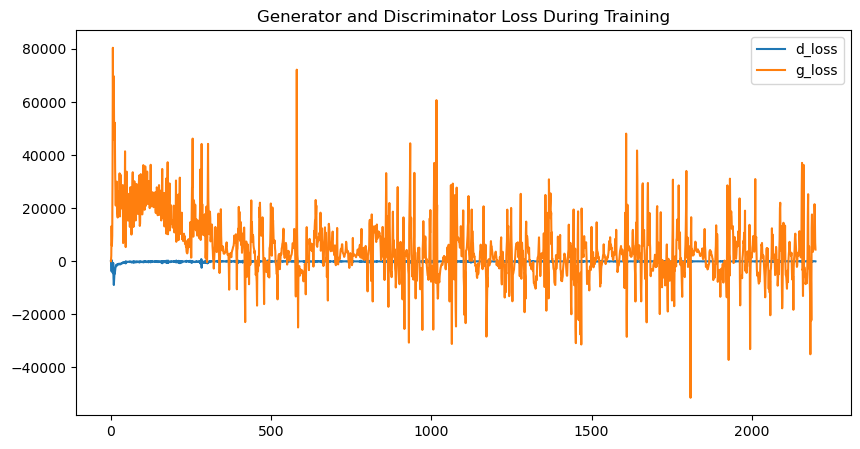

In [ ]:
# Plot training history
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_loss_hist, label='d_loss')
plt.plot(g_loss_hist, label='g_loss')
plt.legend()
plt.show()

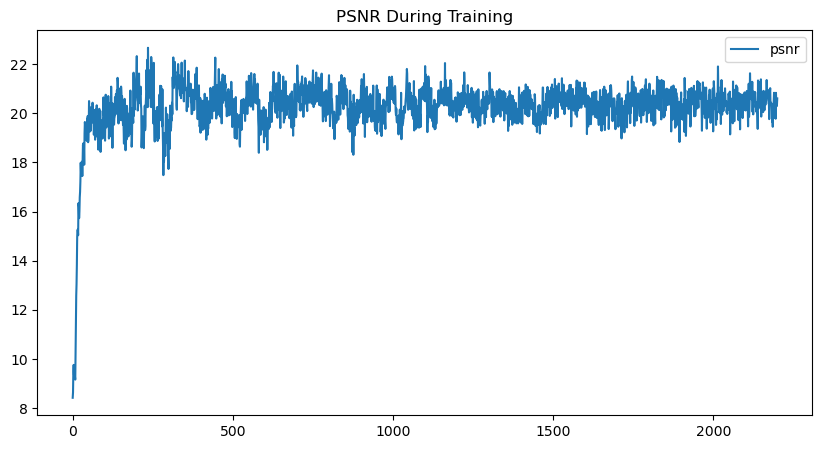

Best PSNR: 22.6634


In [ ]:
plt.figure(figsize=(10,5))
plt.title("PSNR During Training")
plt.plot(psnr_hist, label='psnr')
plt.legend()
plt.show()
print(f"Best PSNR: {best_psnr:.4f}")

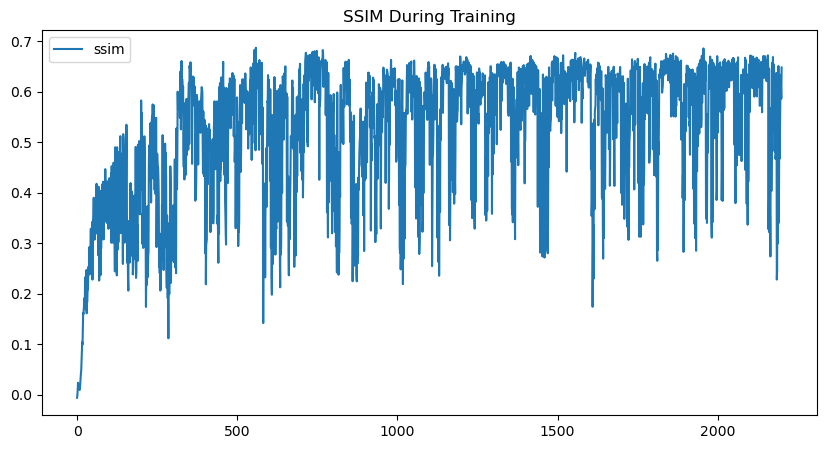

Best SSIM: 0.4809


In [ ]:
plt.figure(figsize=(10,5))
plt.title("SSIM During Training")
plt.plot(ssim_hist, label='ssim')
plt.legend()
plt.show()
print(f"Best SSIM: {best_ssim:.4f}")

In [ ]:
# Save models weights
# model dir should be models/wgan_hr_mm_dd_mm
model_dir = "models/wgan_t1ce_21_21_30_11"
torch.save(best_d_weights, f"{model_dir}/discriminator.pth")
torch.save(best_g_weights, f"{model_dir}/generator.pth")

Critic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2

(-0.5, 529.5, 133.5, -0.5)

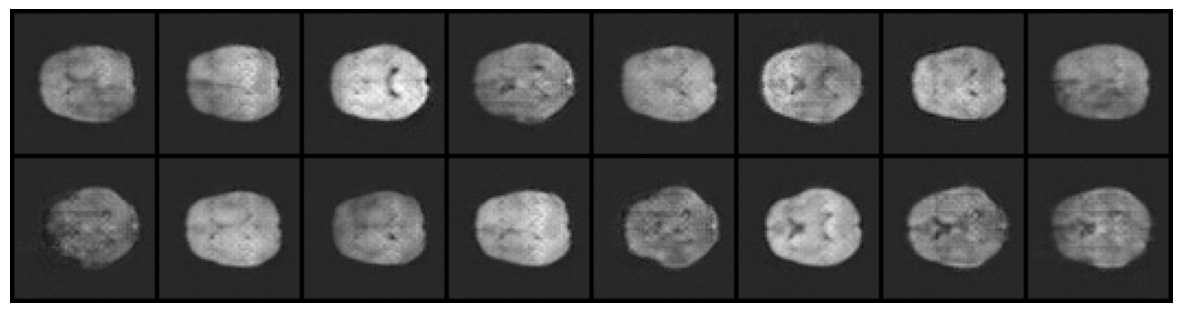

In [ ]:
# model dir should be models/dcgan_hr_mm_dd_mm
model_dir = "models/wgan_t1ce_21_21_30_11"

# Load model and perform inference
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)
print(critic_model)

generator_model = Generator().to(device)
generator_model.apply(weight_init)
print(generator_model)

critic_model.load_state_dict(torch.load(f"{model_dir}/discriminator.pth"))
generator_model.load_state_dict(torch.load(f"{model_dir}/generator.pth"))

generator_model.eval()

fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)

fake = generator_model(fixed_noise).detach().cpu()

plt.figure(figsize=(15, 15))
plt.imshow(
    np.transpose(
        vutils.make_grid(fake, padding=2, normalize=True),
        (1, 2, 0)
    )
)
plt.axis("off")